# Классификация обращений граждан

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

## Установка библиотек

In [2]:
pip install pytorch-transformers

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install transformers

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import random
import io
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score 
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Quadro P5000


## Загрузка данных


In [7]:
import pandas as pd

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
data = pd.read_csv('tatarstan_message_2.csv', encoding='utf8', sep=',')
data = data[['categories', 'description_prep']]

In [8]:
data.sample(5)

,categories,description_prep
19235,Цифровое телевидение,не работает цифровое телевидение на современно...
19568,Благоустройство территории,на ново азинская с опоры фонаря свисает железя...
10745,Благоустройство территории,очистите крышу приведите ее в нормативный вид ...
9320,Благоустройство территории,у здания по улице татарстан аншлаг пришел в не...
9359,Благоустройство территории,вдоль пр московского по пути с автозаводского ...


In [9]:
sentences = ["[CLS] " + str(x) + " [SEP]" for x in data['description_prep']]
#len_s = len(sentences)//2
#labels = pd.Series([[0]] * len_s + [[1]] * (len(sentences) - len_s -10 ) + [[2]] * 10).values.tolist()
#labels = pd.get_dummies(labels).values.tolist()
labels = pd.get_dummies(data['categories'])
label_names = labels.columns.tolist()
labels.columns = range(len(labels.columns))
labels = labels * labels.columns
labels['sum'] = labels.sum(axis=1)
num_labels = max(labels['sum']) + 1
labels = [[lab] for lab in labels['sum']]

print(num_labels)

26


In [10]:
print(labels)

[[2], [2], [23], [2], [23], [16], [2], [2], [23], [23], [23], [2], [2], [2], [1], [15], [23], [2], [23], [2], [1], [1], [2], [23], [2], [23], [23], [23], [9], [14], [15], [15], [1], [23], [2], [2], [15], [23], [2], [2], [2], [2], [2], [23], [16], [11], [16], [2], [23], [23], [2], [14], [2], [16], [23], [23], [21], [1], [2], [23], [23], [2], [16], [1], [23], [23], [2], [2], [23], [2], [2], [2], [23], [10], [10], [10], [10], [10], [10], [10], [10], [10], [16], [16], [14], [1], [18], [14], [2], [23], [23], [2], [23], [2], [2], [2], [23], [2], [2], [23], [23], [23], [2], [2], [2], [23], [23], [1], [23], [23], [23], [23], [15], [23], [23], [2], [23], [23], [2], [23], [23], [8], [2], [23], [23], [23], [15], [2], [2], [2], [23], [2], [23], [23], [23], [8], [2], [2], [2], [2], [2], [23], [2], [2], [23], [23], [1], [2], [23], [2], [23], [2], [2], [23], [23], [1], [2], [2], [2], [2], [23], [14], [23], [15], [2], [23], [23], [23], [2], [23], [2], [14], [21], [23], [14], [23], [12], [2], [2], [23]

In [11]:
print(sentences[1000])

[CLS] дом подьезда имеет подъезд лестница от снега вычещина а богом забытый что за привелегия для мы тоже люди почему я должна идти на другой край дома [SEP]


In [12]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.2)

In [13]:
print(len(train_gt), len(test_gt))

18864 4717


## Inputs

In [14]:
#скачиваем модели BERT
import os
import requests
import zipfile
import tarfile
from pathlib import Path
"""
#модель от Сбербанка
model_dir = '/notebooks/bert_model_from_sber/'
model_name = 'sbert_cased_L-24_H-1024_A-16_pytorch.zip'
url = r"https://storage.googleapis.com/bert_resourses/sbert_nlu/sbert_cased_L-24_H-1024_A-16_pytorch.zip"
model_path = r'/notebooks/bert_model_from_sber/cased_L-24_H-1024_A-16_pytorch'
"""
#модель RUBERT deeppavlov
model_dir = '/notebooks/RUBERT_deeppavlov/'
model_name = 'rubert_cased_L-12_H-768_A-12_pt.tar.gz'
url = r"http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz"
model_path = r'/notebooks/RUBERT_deeppavlov/rubert_cased_L-12_H-768_A-12_pt'
"""
#модель RUBERT deeppavlov предложения
model_dir = '/notebooks/RUBERT_deeppavlov_sentence/'
model_name = 'sentence_ru_cased_L-12_H-768_A-12_pt.tar.gz'
url = r"http://files.deeppavlov.ai/deeppavlov_data/bert/sentence_ru_cased_L-12_H-768_A-12_pt.tar.gz"
model_path = r'/notebooks/RUBERT_deeppavlov_sentence/sentence_ru_cased_L-12_H-768_A-12_pt'

#модель RUBERT deeppavlov разговорный
model_dir = '/notebooks/RUBERT_deeppavlov_conversational/'
model_name = 'conversational_cased_L-12_H-768_A-12_pt.tar.gz'
url = r"http://files.deeppavlov.ai/deeppavlov_data/bert/conversational_cased_L-12_H-768_A-12_pt.tar.gz"
model_path = r'/notebooks/RUBERT_deeppavlov_conversational/conversational_cased_L-12_H-768_A-12_pt'

#модель BERT мультиязычный deeppavlov
model_dir = '/notebooks/BERT_deeppavlov_multi/'
model_name = 'sentence_multi_cased_L-12_H-768_A-12_pt.tar.gz'
url = r"http://files.deeppavlov.ai/deeppavlov_data/bert/sentence_multi_cased_L-12_H-768_A-12_pt.tar.gz"
model_path = r'/notebooks/BERT_deeppavlov_multi/sentence_multi_cased_L-12_H-768_A-12_pt'
"""

# Create output directory if needed
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    path = Path(model_name)
    f=open(os.path.join(model_dir, model_name), "ab+") #открываем файл для записи, в режиме wb
    ufr = requests.get(url) #делаем запрос
    f.write(ufr.content) #записываем содержимое в файл; как видите - content запроса
    f.close()
    
    if path.suffix == ".gz":
        tar = tarfile.open(os.path.join(model_dir, model_name), "r:gz")
        tar.extractall(model_dir)
        tar.close()
    elif path.suffix == ".tar":
        tar = tarfile.open(os.path.join(model_dir, model_name), "r:")
        tar.extractall(model_dir)
        tar.close()
    elif path.suffix == ".zip":    
        dir_zip = zipfile.ZipFile(os.path.join(model_dir, model_name))
        dir_zip.extractall(model_dir)
        dir_zip.close()
                              
    os.remove(os.path.join(model_dir, model_name))   

In [15]:
#загружаем токенизатор BERT и разбиваем текст на токены
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained(model_path, do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[1000])

['[CLS]', 'с', 'приходом', 'весны', 'снег', 'во', 'дворе', 'раст', '##ая', '##л', 'и', 'превратил', 'парковку', 'в', 'большую', 'луж', '##у', 'также', 'эта', 'луж', '##а', 'образуется', 'после', 'сильных', 'дожд', '##еи', 'летом', 'вес', '##но', '##и', 'и', 'осенью', 'необходимо', 'сделать', 'водоот', '##воды', 'т', 'к', 'борд', '##юры', 'не', 'дают', 'уходить', 'воде', '[SEP]']


BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: выходные метки
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [16]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=50,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [17]:
print(input_ids[1])

[   101  25596   2630  81767  50507  26745   6676  69692  16066  53096
  33573   1516  16538  32900 106683   1514   2841  39389  55417    852
  18960  37880   1758  29819   1671    852  63183  43081 115024    851
  11302 117695  12240    102      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]


In [18]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [19]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [20]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [21]:
train_labels

tensor([[ 2],
        [10],
        [ 2],
        ...,
        [ 1],
        [ 2],
        [23]])

Создание загрузчиков данных

In [22]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [23]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [24]:
from pytorch_transformers import AdamW, BertForSequenceClassification

Аналогичные модели есть и для других задач:

In [25]:
from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

In [26]:
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=num_labels) #"bert-base-uncased"
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [27]:
#посмотрим параметры модели

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

Теперь, когда наша модель загружена, нам нужно получить гиперпараметры обучения из сохраненной модели.

Для точной настройки авторы рекомендуют выбирать из следующих значений (из Приложения A.3 документа BERT ):

Размер партии: 16, 32
Скорость обучения (Адам): 5e-5, 3e-5, 2e-5
Количество эпох: 2, 3, 4
Мы выбрали:

Размер партии: 32 (устанавливается при создании наших загрузчиков данных)
Скорость обучения: 2e-5
Эпох: 4
Параметр epsilon eps = 1e-8- это «очень маленькое число, чтобы предотвратить любое деление на ноль в реализации»

In [28]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, 
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.)
                 )

In [29]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [30]:
#вспомогательная функция для вычисления точности

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [31]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [32]:
#дообучение и валидация модели

from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Обучение
    # Переводим модель в training mode
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # если не сделать .zero_grad(), градиенты будут накапливаться
        optimizer.zero_grad()

        # Forward pass
        (loss, logits) = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        train_loss_set.append(loss.item())  
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Обновляем параметры и делаем шаг используя посчитанные градиенты
        optimizer.step()
        scheduler.step()
        
        #средний loss по всем батчам
        avg_train_loss = total_train_loss / len(train_dataloader)
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # Рисуем график
        #clear_output(True)
        #plt.plot(train_loss_set)
        #plt.title("Training loss")
        #plt.xlabel("Batch")
        #plt.ylabel("Loss")
        #plt.show()


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    
    # Переводим модель в evaluation mode
    model.eval()
    
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    valid_preds, valid_labels = [], []

    for batch in validation_dataloader:   
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)

        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # При использовании .no_grad() модель не будет считать и хранить градиенты.
        # Это ускорит процесс предсказания меток для валидационных данных.
        with torch.no_grad():
            (loss, logits) = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Перемещаем logits и метки классов на CPU для дальнейшей работы
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...


/usr/local/lib/python3.6/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)



  Average training loss: 0.01
  Training epcoh took: 0:00:00

  Average training loss: 0.01
  Training epcoh took: 0:00:01

  Average training loss: 0.02
  Training epcoh took: 0:00:01

  Average training loss: 0.02
  Training epcoh took: 0:00:01

  Average training loss: 0.03
  Training epcoh took: 0:00:01

  Average training loss: 0.03
  Training epcoh took: 0:00:02

  Average training loss: 0.04
  Training epcoh took: 0:00:02

  Average training loss: 0.05
  Training epcoh took: 0:00:02

  Average training loss: 0.05
  Training epcoh took: 0:00:02

  Average training loss: 0.05
  Training epcoh took: 0:00:03

  Average training loss: 0.06
  Training epcoh took: 0:00:03

  Average training loss: 0.06
  Training epcoh took: 0:00:03

  Average training loss: 0.07
  Training epcoh took: 0:00:03

  Average training loss: 0.07
  Training epcoh took: 0:00:04

  Average training loss: 0.08
  Training epcoh took: 0:00:04

  Average training loss: 0.08
  Training epcoh took: 0:00:04

  Avera


  Average training loss: 0.41
  Training epcoh took: 0:00:35

  Average training loss: 0.41
  Training epcoh took: 0:00:35

  Average training loss: 0.41
  Training epcoh took: 0:00:35

  Average training loss: 0.41
  Training epcoh took: 0:00:35

  Average training loss: 0.41
  Training epcoh took: 0:00:36

  Average training loss: 0.42
  Training epcoh took: 0:00:36

  Average training loss: 0.42
  Training epcoh took: 0:00:36

  Average training loss: 0.42
  Training epcoh took: 0:00:36

  Average training loss: 0.42
  Training epcoh took: 0:00:37

  Average training loss: 0.42
  Training epcoh took: 0:00:37

  Average training loss: 0.43
  Training epcoh took: 0:00:37

  Average training loss: 0.43
  Training epcoh took: 0:00:37

  Average training loss: 0.43
  Training epcoh took: 0:00:38

  Average training loss: 0.43
  Training epcoh took: 0:00:38

  Average training loss: 0.43
  Training epcoh took: 0:00:38

  Average training loss: 0.43
  Training epcoh took: 0:00:38

  Avera


  Average training loss: 0.62
  Training epcoh took: 0:01:09

  Average training loss: 0.62
  Training epcoh took: 0:01:09

  Average training loss: 0.62
  Training epcoh took: 0:01:09

  Average training loss: 0.62
  Training epcoh took: 0:01:10

  Average training loss: 0.63
  Training epcoh took: 0:01:10

  Average training loss: 0.63
  Training epcoh took: 0:01:10

  Average training loss: 0.63
  Training epcoh took: 0:01:10

  Average training loss: 0.63
  Training epcoh took: 0:01:11

  Average training loss: 0.63
  Training epcoh took: 0:01:11

  Average training loss: 0.63
  Training epcoh took: 0:01:11

  Average training loss: 0.63
  Training epcoh took: 0:01:11

  Average training loss: 0.63
  Training epcoh took: 0:01:12

  Average training loss: 0.64
  Training epcoh took: 0:01:12

  Average training loss: 0.64
  Training epcoh took: 0:01:12

  Average training loss: 0.64
  Training epcoh took: 0:01:12

  Average training loss: 0.64
  Training epcoh took: 0:01:13

  Avera


  Average training loss: 0.79
  Training epcoh took: 0:01:43

  Average training loss: 0.79
  Training epcoh took: 0:01:43

  Average training loss: 0.79
  Training epcoh took: 0:01:43

  Average training loss: 0.79
  Training epcoh took: 0:01:44

  Average training loss: 0.79
  Training epcoh took: 0:01:44

  Average training loss: 0.80
  Training epcoh took: 0:01:44

  Average training loss: 0.80
  Training epcoh took: 0:01:45

  Average training loss: 0.80
  Training epcoh took: 0:01:45

  Average training loss: 0.80
  Training epcoh took: 0:01:45

  Average training loss: 0.80
  Training epcoh took: 0:01:45
  Batch   400  of    531.    Elapsed: 0:01:45.

  Average training loss: 0.80
  Training epcoh took: 0:01:46

  Average training loss: 0.80
  Training epcoh took: 0:01:46

  Average training loss: 0.80
  Training epcoh took: 0:01:46

  Average training loss: 0.81
  Training epcoh took: 0:01:46

  Average training loss: 0.81
  Training epcoh took: 0:01:47

  Average training los


  Average training loss: 0.95
  Training epcoh took: 0:02:17

  Average training loss: 0.95
  Training epcoh took: 0:02:17

  Average training loss: 0.95
  Training epcoh took: 0:02:18

  Average training loss: 0.95
  Training epcoh took: 0:02:18

  Average training loss: 0.95
  Training epcoh took: 0:02:18

  Average training loss: 0.95
  Training epcoh took: 0:02:18

  Average training loss: 0.95
  Training epcoh took: 0:02:19

  Average training loss: 0.95
  Training epcoh took: 0:02:19

  Average training loss: 0.96
  Training epcoh took: 0:02:19

  Average training loss: 0.96
  Training epcoh took: 0:02:19

  Average training loss: 0.96
  Training epcoh took: 0:02:20

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.54
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:00:00

  Average training loss: 0.00
  Training epcoh took: 0:00:01

  Average training loss: 0.00
  Training epcoh took: 0:00:0


  Average training loss: 0.11
  Training epcoh took: 0:00:31

  Average training loss: 0.11
  Training epcoh took: 0:00:31
  Batch   120  of    531.    Elapsed: 0:00:31.

  Average training loss: 0.11
  Training epcoh took: 0:00:32

  Average training loss: 0.11
  Training epcoh took: 0:00:32

  Average training loss: 0.12
  Training epcoh took: 0:00:32

  Average training loss: 0.12
  Training epcoh took: 0:00:32

  Average training loss: 0.12
  Training epcoh took: 0:00:33

  Average training loss: 0.12
  Training epcoh took: 0:00:33

  Average training loss: 0.12
  Training epcoh took: 0:00:33

  Average training loss: 0.12
  Training epcoh took: 0:00:33

  Average training loss: 0.12
  Training epcoh took: 0:00:34

  Average training loss: 0.12
  Training epcoh took: 0:00:34

  Average training loss: 0.12
  Training epcoh took: 0:00:34

  Average training loss: 0.12
  Training epcoh took: 0:00:34

  Average training loss: 0.12
  Training epcoh took: 0:00:35

  Average training los


  Average training loss: 0.23
  Training epcoh took: 0:01:05

  Average training loss: 0.23
  Training epcoh took: 0:01:05

  Average training loss: 0.23
  Training epcoh took: 0:01:06

  Average training loss: 0.23
  Training epcoh took: 0:01:06

  Average training loss: 0.23
  Training epcoh took: 0:01:06

  Average training loss: 0.23
  Training epcoh took: 0:01:06

  Average training loss: 0.23
  Training epcoh took: 0:01:07

  Average training loss: 0.24
  Training epcoh took: 0:01:07

  Average training loss: 0.24
  Training epcoh took: 0:01:07

  Average training loss: 0.24
  Training epcoh took: 0:01:07

  Average training loss: 0.24
  Training epcoh took: 0:01:08

  Average training loss: 0.24
  Training epcoh took: 0:01:08

  Average training loss: 0.24
  Training epcoh took: 0:01:08

  Average training loss: 0.24
  Training epcoh took: 0:01:09

  Average training loss: 0.24
  Training epcoh took: 0:01:09

  Average training loss: 0.24
  Training epcoh took: 0:01:09

  Avera


  Average training loss: 0.34
  Training epcoh took: 0:01:39

  Average training loss: 0.34
  Training epcoh took: 0:01:39

  Average training loss: 0.34
  Training epcoh took: 0:01:40

  Average training loss: 0.34
  Training epcoh took: 0:01:40

  Average training loss: 0.34
  Training epcoh took: 0:01:40

  Average training loss: 0.34
  Training epcoh took: 0:01:40

  Average training loss: 0.34
  Training epcoh took: 0:01:41

  Average training loss: 0.34
  Training epcoh took: 0:01:41

  Average training loss: 0.34
  Training epcoh took: 0:01:41

  Average training loss: 0.34
  Training epcoh took: 0:01:41

  Average training loss: 0.34
  Training epcoh took: 0:01:42

  Average training loss: 0.34
  Training epcoh took: 0:01:42

  Average training loss: 0.35
  Training epcoh took: 0:01:42

  Average training loss: 0.35
  Training epcoh took: 0:01:42

  Average training loss: 0.35
  Training epcoh took: 0:01:43

  Average training loss: 0.35
  Training epcoh took: 0:01:43

  Avera


  Average training loss: 0.44
  Training epcoh took: 0:02:13

  Average training loss: 0.44
  Training epcoh took: 0:02:13

  Average training loss: 0.44
  Training epcoh took: 0:02:14

  Average training loss: 0.44
  Training epcoh took: 0:02:14

  Average training loss: 0.44
  Training epcoh took: 0:02:14

  Average training loss: 0.44
  Training epcoh took: 0:02:14

  Average training loss: 0.44
  Training epcoh took: 0:02:15

  Average training loss: 0.44
  Training epcoh took: 0:02:15

  Average training loss: 0.45
  Training epcoh took: 0:02:15

  Average training loss: 0.45
  Training epcoh took: 0:02:15

  Average training loss: 0.45
  Training epcoh took: 0:02:16

  Average training loss: 0.45
  Training epcoh took: 0:02:16
  Batch   520  of    531.    Elapsed: 0:02:16.

  Average training loss: 0.45
  Training epcoh took: 0:02:16

  Average training loss: 0.45
  Training epcoh took: 0:02:16

  Average training loss: 0.45
  Training epcoh took: 0:02:17

  Average training los


  Average training loss: 0.06
  Training epcoh took: 0:00:28

  Average training loss: 0.06
  Training epcoh took: 0:00:28

  Average training loss: 0.06
  Training epcoh took: 0:00:28

  Average training loss: 0.06
  Training epcoh took: 0:00:28

  Average training loss: 0.06
  Training epcoh took: 0:00:29

  Average training loss: 0.07
  Training epcoh took: 0:00:29

  Average training loss: 0.07
  Training epcoh took: 0:00:29

  Average training loss: 0.07
  Training epcoh took: 0:00:30

  Average training loss: 0.07
  Training epcoh took: 0:00:30

  Average training loss: 0.07
  Training epcoh took: 0:00:30

  Average training loss: 0.07
  Training epcoh took: 0:00:30

  Average training loss: 0.07
  Training epcoh took: 0:00:31

  Average training loss: 0.07
  Training epcoh took: 0:00:31

  Average training loss: 0.07
  Training epcoh took: 0:00:31

  Average training loss: 0.07
  Training epcoh took: 0:00:31
  Batch   120  of    531.    Elapsed: 0:00:31.

  Average training los


  Average training loss: 0.15
  Training epcoh took: 0:01:02

  Average training loss: 0.15
  Training epcoh took: 0:01:02

  Average training loss: 0.15
  Training epcoh took: 0:01:02

  Average training loss: 0.15
  Training epcoh took: 0:01:03

  Average training loss: 0.15
  Training epcoh took: 0:01:03
  Batch   240  of    531.    Elapsed: 0:01:03.

  Average training loss: 0.15
  Training epcoh took: 0:01:03

  Average training loss: 0.15
  Training epcoh took: 0:01:03

  Average training loss: 0.15
  Training epcoh took: 0:01:04

  Average training loss: 0.15
  Training epcoh took: 0:01:04

  Average training loss: 0.15
  Training epcoh took: 0:01:04

  Average training loss: 0.15
  Training epcoh took: 0:01:04

  Average training loss: 0.15
  Training epcoh took: 0:01:05

  Average training loss: 0.15
  Training epcoh took: 0:01:05

  Average training loss: 0.15
  Training epcoh took: 0:01:05

  Average training loss: 0.15
  Training epcoh took: 0:01:05

  Average training los


  Average training loss: 0.22
  Training epcoh took: 0:01:36

  Average training loss: 0.22
  Training epcoh took: 0:01:36

  Average training loss: 0.22
  Training epcoh took: 0:01:36

  Average training loss: 0.22
  Training epcoh took: 0:01:37

  Average training loss: 0.22
  Training epcoh took: 0:01:37

  Average training loss: 0.23
  Training epcoh took: 0:01:37

  Average training loss: 0.23
  Training epcoh took: 0:01:37

  Average training loss: 0.23
  Training epcoh took: 0:01:38

  Average training loss: 0.23
  Training epcoh took: 0:01:38

  Average training loss: 0.23
  Training epcoh took: 0:01:38

  Average training loss: 0.23
  Training epcoh took: 0:01:38

  Average training loss: 0.23
  Training epcoh took: 0:01:39

  Average training loss: 0.23
  Training epcoh took: 0:01:39

  Average training loss: 0.23
  Training epcoh took: 0:01:39

  Average training loss: 0.23
  Training epcoh took: 0:01:39

  Average training loss: 0.23
  Training epcoh took: 0:01:40

  Avera


  Average training loss: 0.30
  Training epcoh took: 0:02:10

  Average training loss: 0.30
  Training epcoh took: 0:02:10

  Average training loss: 0.30
  Training epcoh took: 0:02:10

  Average training loss: 0.30
  Training epcoh took: 0:02:11

  Average training loss: 0.30
  Training epcoh took: 0:02:11

  Average training loss: 0.30
  Training epcoh took: 0:02:11

  Average training loss: 0.30
  Training epcoh took: 0:02:11

  Average training loss: 0.30
  Training epcoh took: 0:02:12

  Average training loss: 0.30
  Training epcoh took: 0:02:12

  Average training loss: 0.30
  Training epcoh took: 0:02:12

  Average training loss: 0.30
  Training epcoh took: 0:02:12

  Average training loss: 0.31
  Training epcoh took: 0:02:13

  Average training loss: 0.31
  Training epcoh took: 0:02:13

  Average training loss: 0.31
  Training epcoh took: 0:02:13

  Average training loss: 0.31
  Training epcoh took: 0:02:13

  Average training loss: 0.31
  Training epcoh took: 0:02:14

  Avera


  Average training loss: 0.04
  Training epcoh took: 0:00:24

  Average training loss: 0.04
  Training epcoh took: 0:00:25

  Average training loss: 0.04
  Training epcoh took: 0:00:25

  Average training loss: 0.04
  Training epcoh took: 0:00:25

  Average training loss: 0.04
  Training epcoh took: 0:00:25

  Average training loss: 0.04
  Training epcoh took: 0:00:26

  Average training loss: 0.04
  Training epcoh took: 0:00:26

  Average training loss: 0.04
  Training epcoh took: 0:00:26

  Average training loss: 0.05
  Training epcoh took: 0:00:26

  Average training loss: 0.05
  Training epcoh took: 0:00:27

  Average training loss: 0.05
  Training epcoh took: 0:00:27

  Average training loss: 0.05
  Training epcoh took: 0:00:27

  Average training loss: 0.05
  Training epcoh took: 0:00:27

  Average training loss: 0.05
  Training epcoh took: 0:00:28

  Average training loss: 0.05
  Training epcoh took: 0:00:28

  Average training loss: 0.05
  Training epcoh took: 0:00:28

  Avera


  Average training loss: 0.10
  Training epcoh took: 0:00:58

  Average training loss: 0.10
  Training epcoh took: 0:00:59

  Average training loss: 0.10
  Training epcoh took: 0:00:59

  Average training loss: 0.11
  Training epcoh took: 0:00:59

  Average training loss: 0.11
  Training epcoh took: 0:00:59

  Average training loss: 0.11
  Training epcoh took: 0:01:00

  Average training loss: 0.11
  Training epcoh took: 0:01:00

  Average training loss: 0.11
  Training epcoh took: 0:01:00

  Average training loss: 0.11
  Training epcoh took: 0:01:00

  Average training loss: 0.11
  Training epcoh took: 0:01:01

  Average training loss: 0.11
  Training epcoh took: 0:01:01

  Average training loss: 0.11
  Training epcoh took: 0:01:01

  Average training loss: 0.11
  Training epcoh took: 0:01:01

  Average training loss: 0.11
  Training epcoh took: 0:01:02

  Average training loss: 0.11
  Training epcoh took: 0:01:02

  Average training loss: 0.11
  Training epcoh took: 0:01:02

  Avera


  Average training loss: 0.16
  Training epcoh took: 0:01:32

  Average training loss: 0.16
  Training epcoh took: 0:01:33

  Average training loss: 0.16
  Training epcoh took: 0:01:33

  Average training loss: 0.16
  Training epcoh took: 0:01:33

  Average training loss: 0.16
  Training epcoh took: 0:01:33

  Average training loss: 0.16
  Training epcoh took: 0:01:34

  Average training loss: 0.16
  Training epcoh took: 0:01:34

  Average training loss: 0.16
  Training epcoh took: 0:01:34
  Batch   360  of    531.    Elapsed: 0:01:34.

  Average training loss: 0.16
  Training epcoh took: 0:01:34

  Average training loss: 0.16
  Training epcoh took: 0:01:35

  Average training loss: 0.16
  Training epcoh took: 0:01:35

  Average training loss: 0.17
  Training epcoh took: 0:01:35

  Average training loss: 0.17
  Training epcoh took: 0:01:35

  Average training loss: 0.17
  Training epcoh took: 0:01:36

  Average training loss: 0.17
  Training epcoh took: 0:01:36

  Average training los


  Average training loss: 0.22
  Training epcoh took: 0:02:06

  Average training loss: 0.22
  Training epcoh took: 0:02:07

  Average training loss: 0.22
  Training epcoh took: 0:02:07

  Average training loss: 0.22
  Training epcoh took: 0:02:07

  Average training loss: 0.22
  Training epcoh took: 0:02:07

  Average training loss: 0.22
  Training epcoh took: 0:02:08

  Average training loss: 0.22
  Training epcoh took: 0:02:08

  Average training loss: 0.22
  Training epcoh took: 0:02:08

  Average training loss: 0.22
  Training epcoh took: 0:02:08

  Average training loss: 0.22
  Training epcoh took: 0:02:09

  Average training loss: 0.22
  Training epcoh took: 0:02:09

  Average training loss: 0.22
  Training epcoh took: 0:02:09

  Average training loss: 0.23
  Training epcoh took: 0:02:09

  Average training loss: 0.23
  Training epcoh took: 0:02:10

  Average training loss: 0.23
  Training epcoh took: 0:02:10

  Average training loss: 0.23
  Training epcoh took: 0:02:10

  Avera

In [33]:
#Рассмотрим сводку тренировочного процесса.

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.96,0.54,0.84,0:02:20,0:00:04
2,0.46,0.48,0.85,0:02:19,0:00:04
3,0.32,0.46,0.86,0:02:19,0:00:04
4,0.24,0.47,0.86,0:02:19,0:00:04


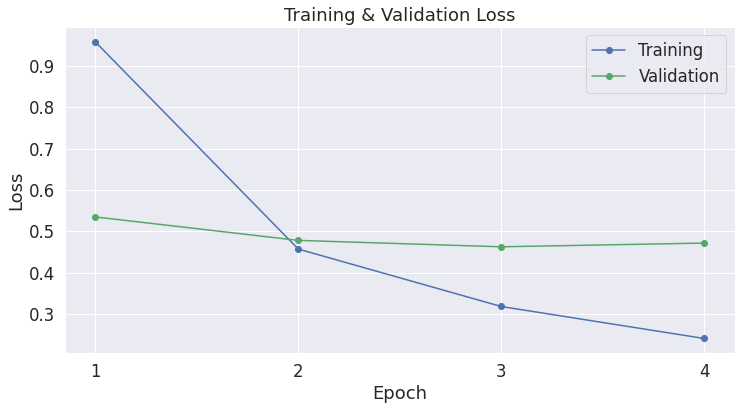

In [34]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [35]:
#сохранение модели

import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/notebooks/BERT_MODEL_PRETRAINED'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to /notebooks/BERT_MODEL_PRETRAINED


('/notebooks/BERT_MODEL_PRETRAINED/vocab.txt',
 '/notebooks/BERT_MODEL_PRETRAINED/special_tokens_map.json',
 '/notebooks/BERT_MODEL_PRETRAINED/added_tokens.json')

In [36]:
#загрузка модели

# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

# Оценка качества на отложенной выборке

In [37]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=50,
    dtype="long",
    truncating="post",
    padding="post"
)

In [38]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_sampler = SequentialSampler(prediction_data)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [39]:
print(f'Predicting labels for {len(input_ids)} test sentences...')

model.eval()
predictions, true_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    
    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и исходные метки
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')
#print(predictions)
#print(true_labels)

Predicting labels for 4717 test sentences...
    DONE.


In [40]:
#вывести процент верно угаданных меток
true_counter = 0
all_counter = 0
for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    for pred_label, true_label in zip(pred_labels_i, true_labels[i]):
        if pred_label==true_label:
            true_counter = true_counter + 1
        all_counter = all_counter + 1
print(f'Positive samples: {true_counter} of {all_counter} ({(true_counter/all_counter)*100} %)')

Positive samples: 4041 of 4717 (85.6688573245707 %)


Расчет метрик качества модели

In [41]:
#Объединяем результаты батчей
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

print(classification_report(flat_true_labels, flat_predictions, digits=5))

              precision    recall  f1-score   support

           0    0.67241   0.62903   0.65000        62
           1    0.96094   0.99194   0.97619       124
           2    0.87265   0.87345   0.87305      2181
           3    0.00000   0.00000   0.00000         3
           4    0.80000   0.76923   0.78431        26
           5    0.72000   0.60000   0.65455        30
           6    0.50000   0.10526   0.17391        19
           7    0.00000   0.00000   0.00000        10
           8    0.61538   0.82759   0.70588        29
           9    0.78049   0.94118   0.85333        34
          10    0.91905   0.95545   0.93689       202
          11    0.00000   0.00000   0.00000         2
          12    0.89418   0.92350   0.90860       183
          13    0.00000   0.00000   0.00000         2
          14    0.91437   0.90332   0.90881       331
          15    0.67797   0.54795   0.60606        73
          16    0.91071   0.92727   0.91892       110
          17    1.00000   0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


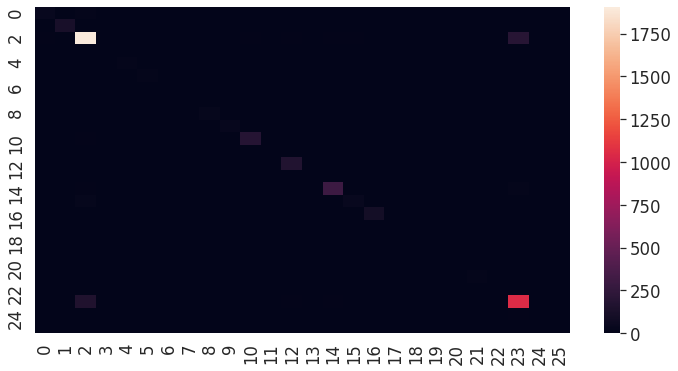

In [42]:
cm = confusion_matrix(flat_true_labels, flat_predictions)
f = sns.heatmap(cm, annot=False)

In [43]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


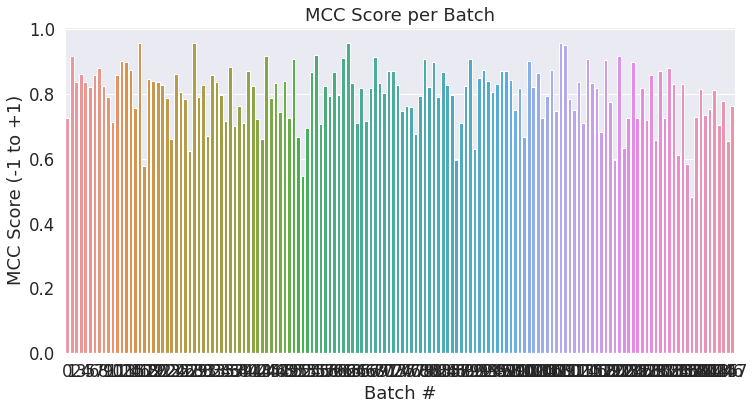

In [44]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Теперь мы объединим результаты для всех батчей и вычислим окончательную оценку MCC.

In [45]:
#Объединяем результаты батчей
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.5f' % mcc)

Total MCC: 0.79645
